In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
from loguru import logger
from dataset_preprocessing.src.utils import generate_histogram
import numpy as np

notebook_dir = os.getcwd()
src_path = os.path.abspath(os.path.join(notebook_dir, 'src'))
sys.path.append(src_path)

In [10]:
observations = pd.read_excel('observations.xlsx', sheet_name='o6ZG24xb')

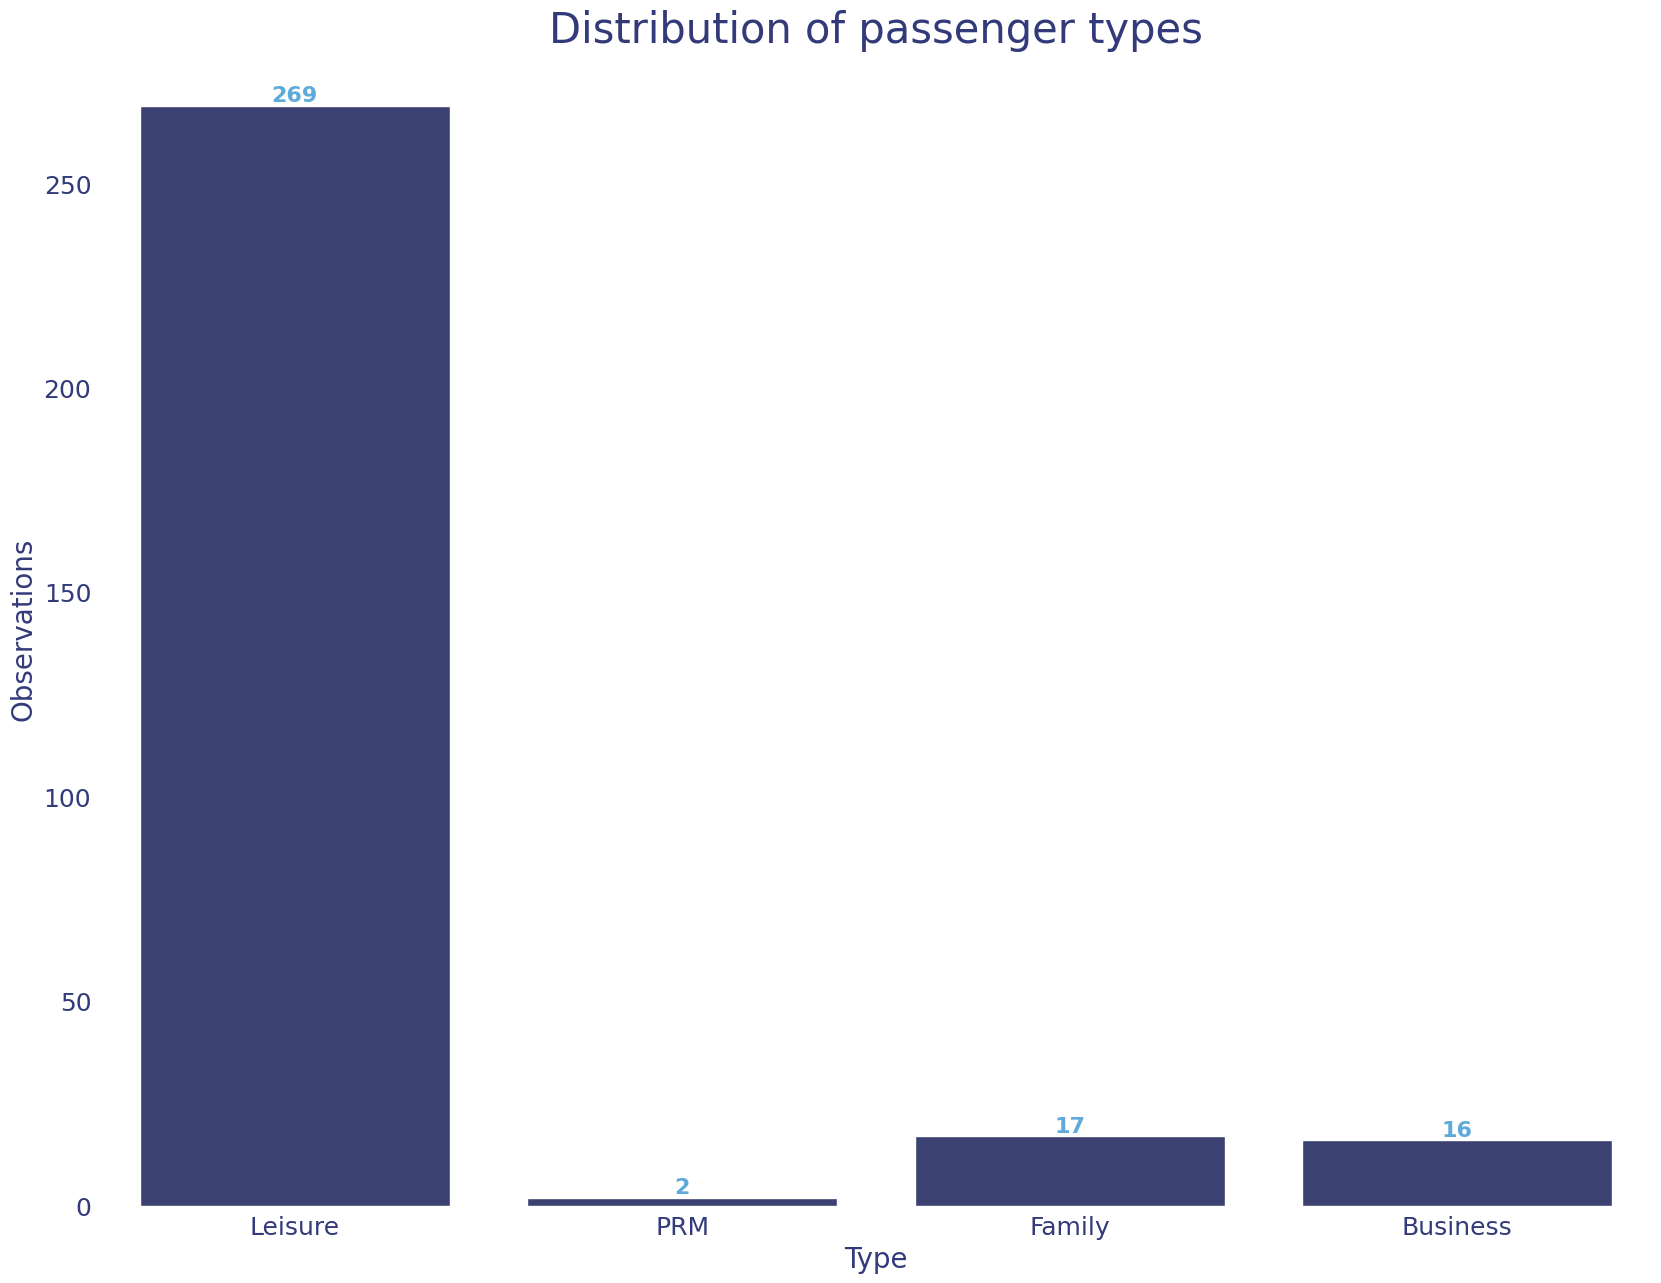

In [11]:
passenger_types = ['Leisure', 'PRM', 'Family', 'Business']
passenger_counts = observations[passenger_types].notna().sum().reset_index()
passenger_counts.columns = ['Type', 'Observations']
generate_histogram(
    passenger_counts,
    title='Distribution of passenger types',
    x='Type',
    y='Observations',
    name_to_save= "passenger_types_histogram.pdf",
    rotation=0,
    xlabel='Type',
    ylabel='Observations',
)

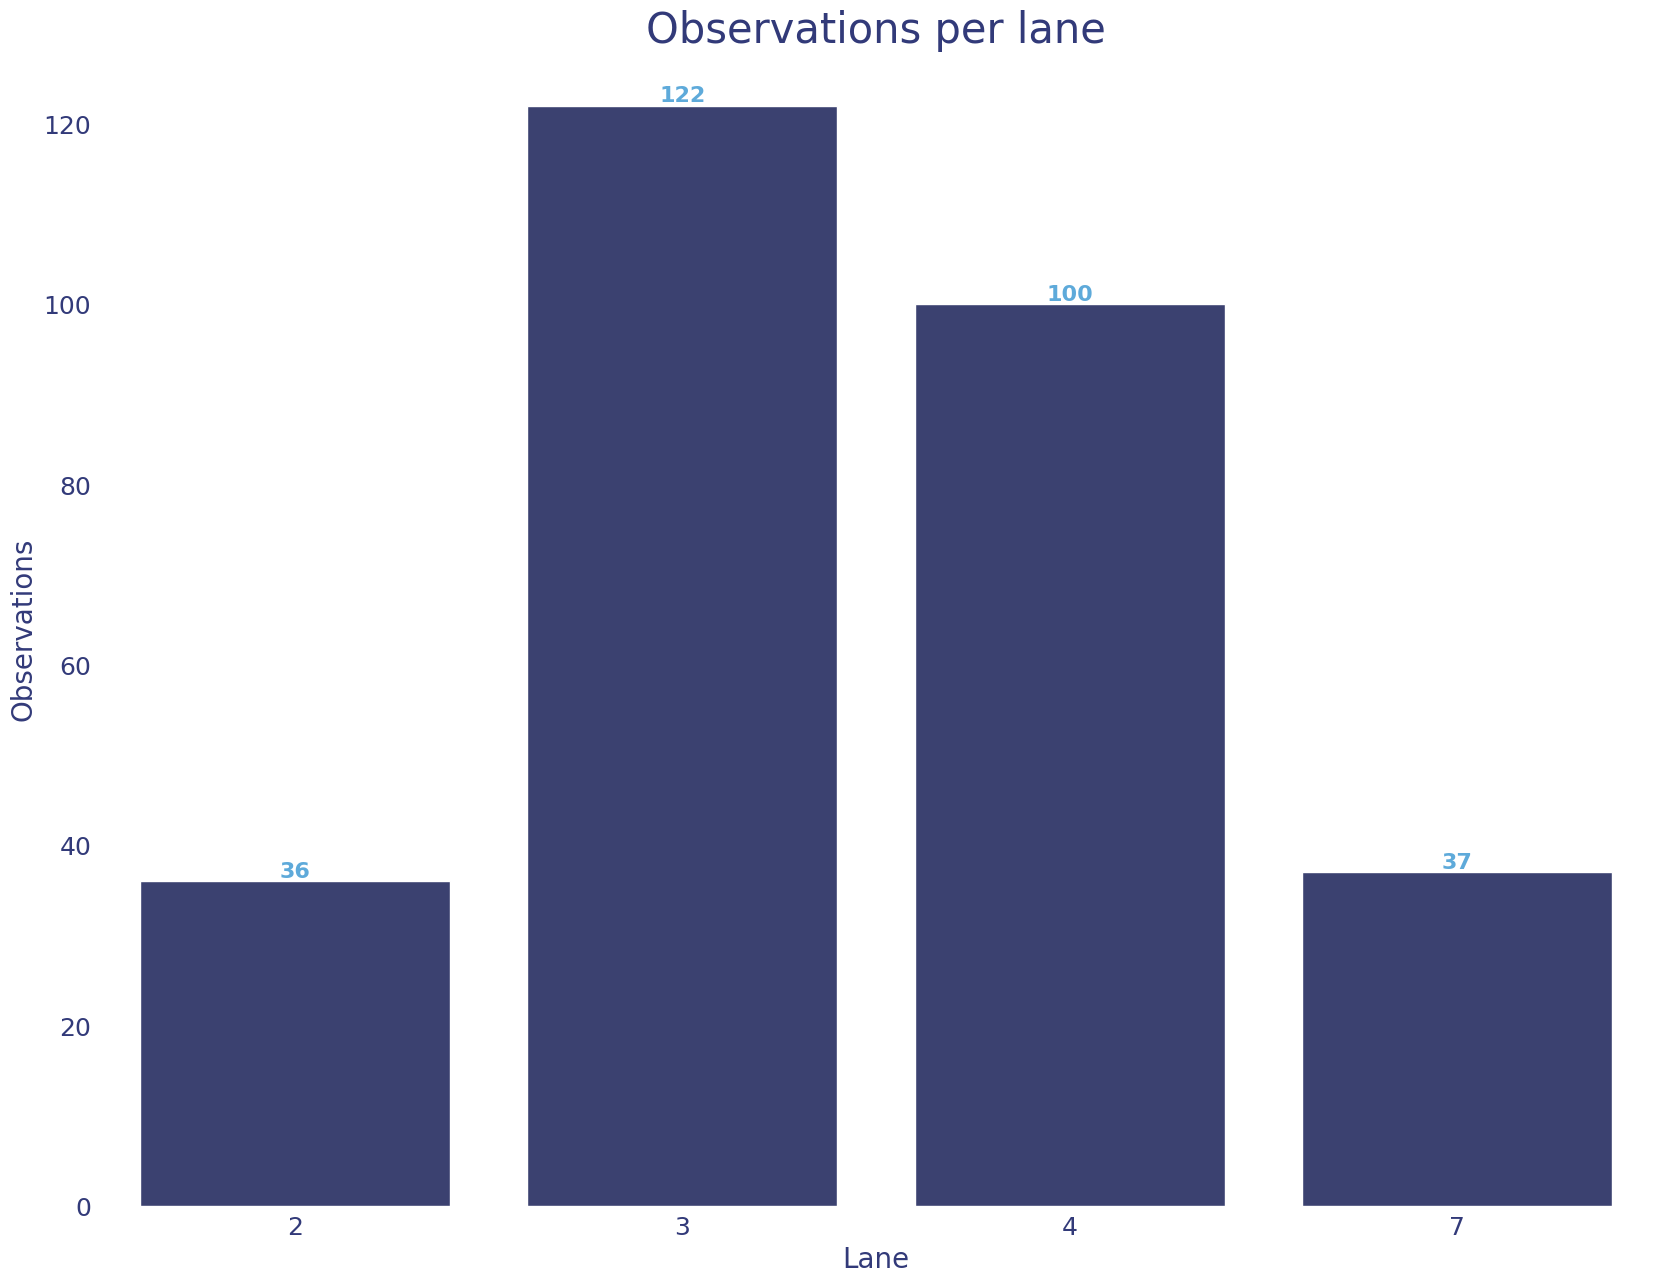

In [12]:
lane_observations = observations["What lane is this measurement being performed at?"].value_counts().reset_index()

generate_histogram(
    lane_observations,
    title='Observations per lane',
    x='What lane is this measurement being performed at?',
    y='count',
    name_to_save= "observations_per_lane_histogram.pdf",
    rotation=0,
    xlabel='Lane',
    ylabel='Observations',
)

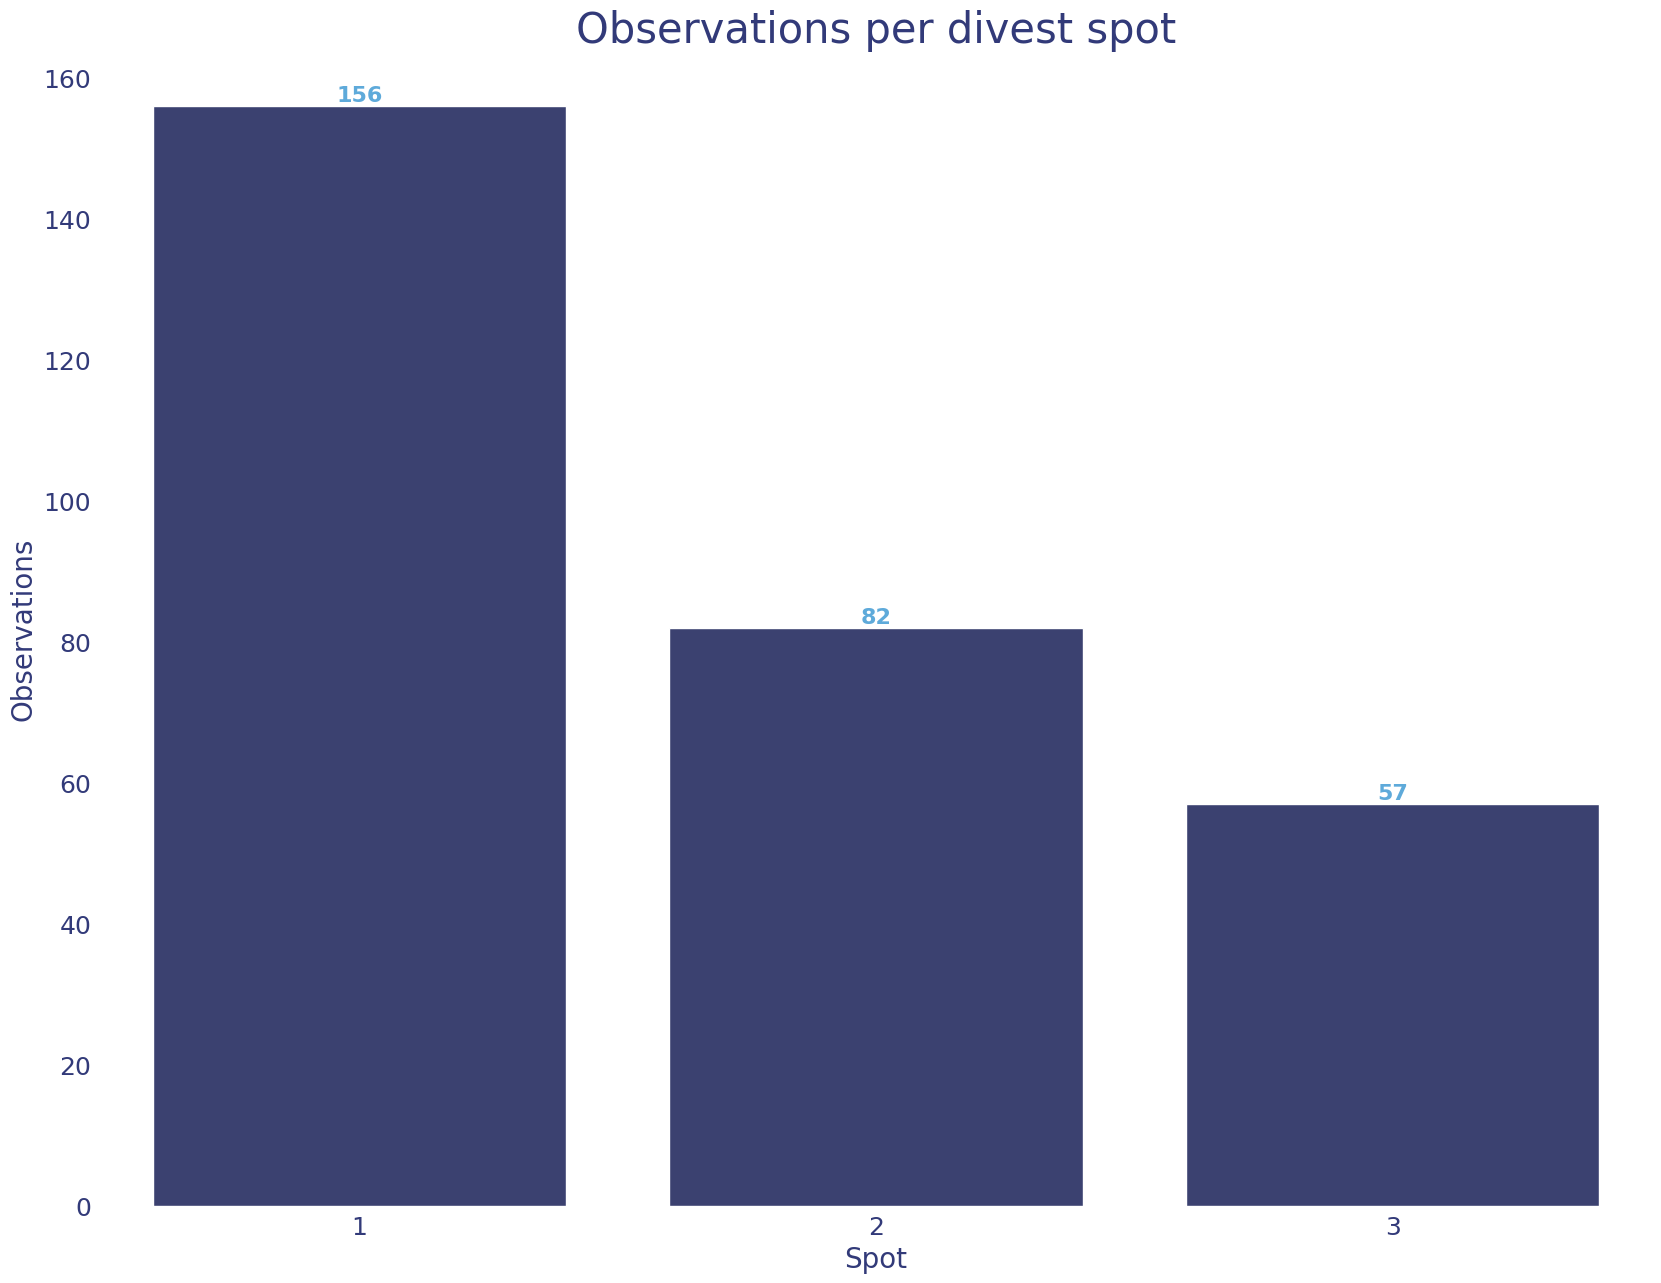

In [13]:
divest_spot_observations = observations["What position is the passenger using?"].value_counts().reset_index()

generate_histogram(
    divest_spot_observations,
    title='Observations per divest spot',
    x='What position is the passenger using?',
    y='count',
    name_to_save= "observations_per_spot_histogram.pdf",
    rotation=0,
    xlabel='Spot',
    ylabel='Observations',
)

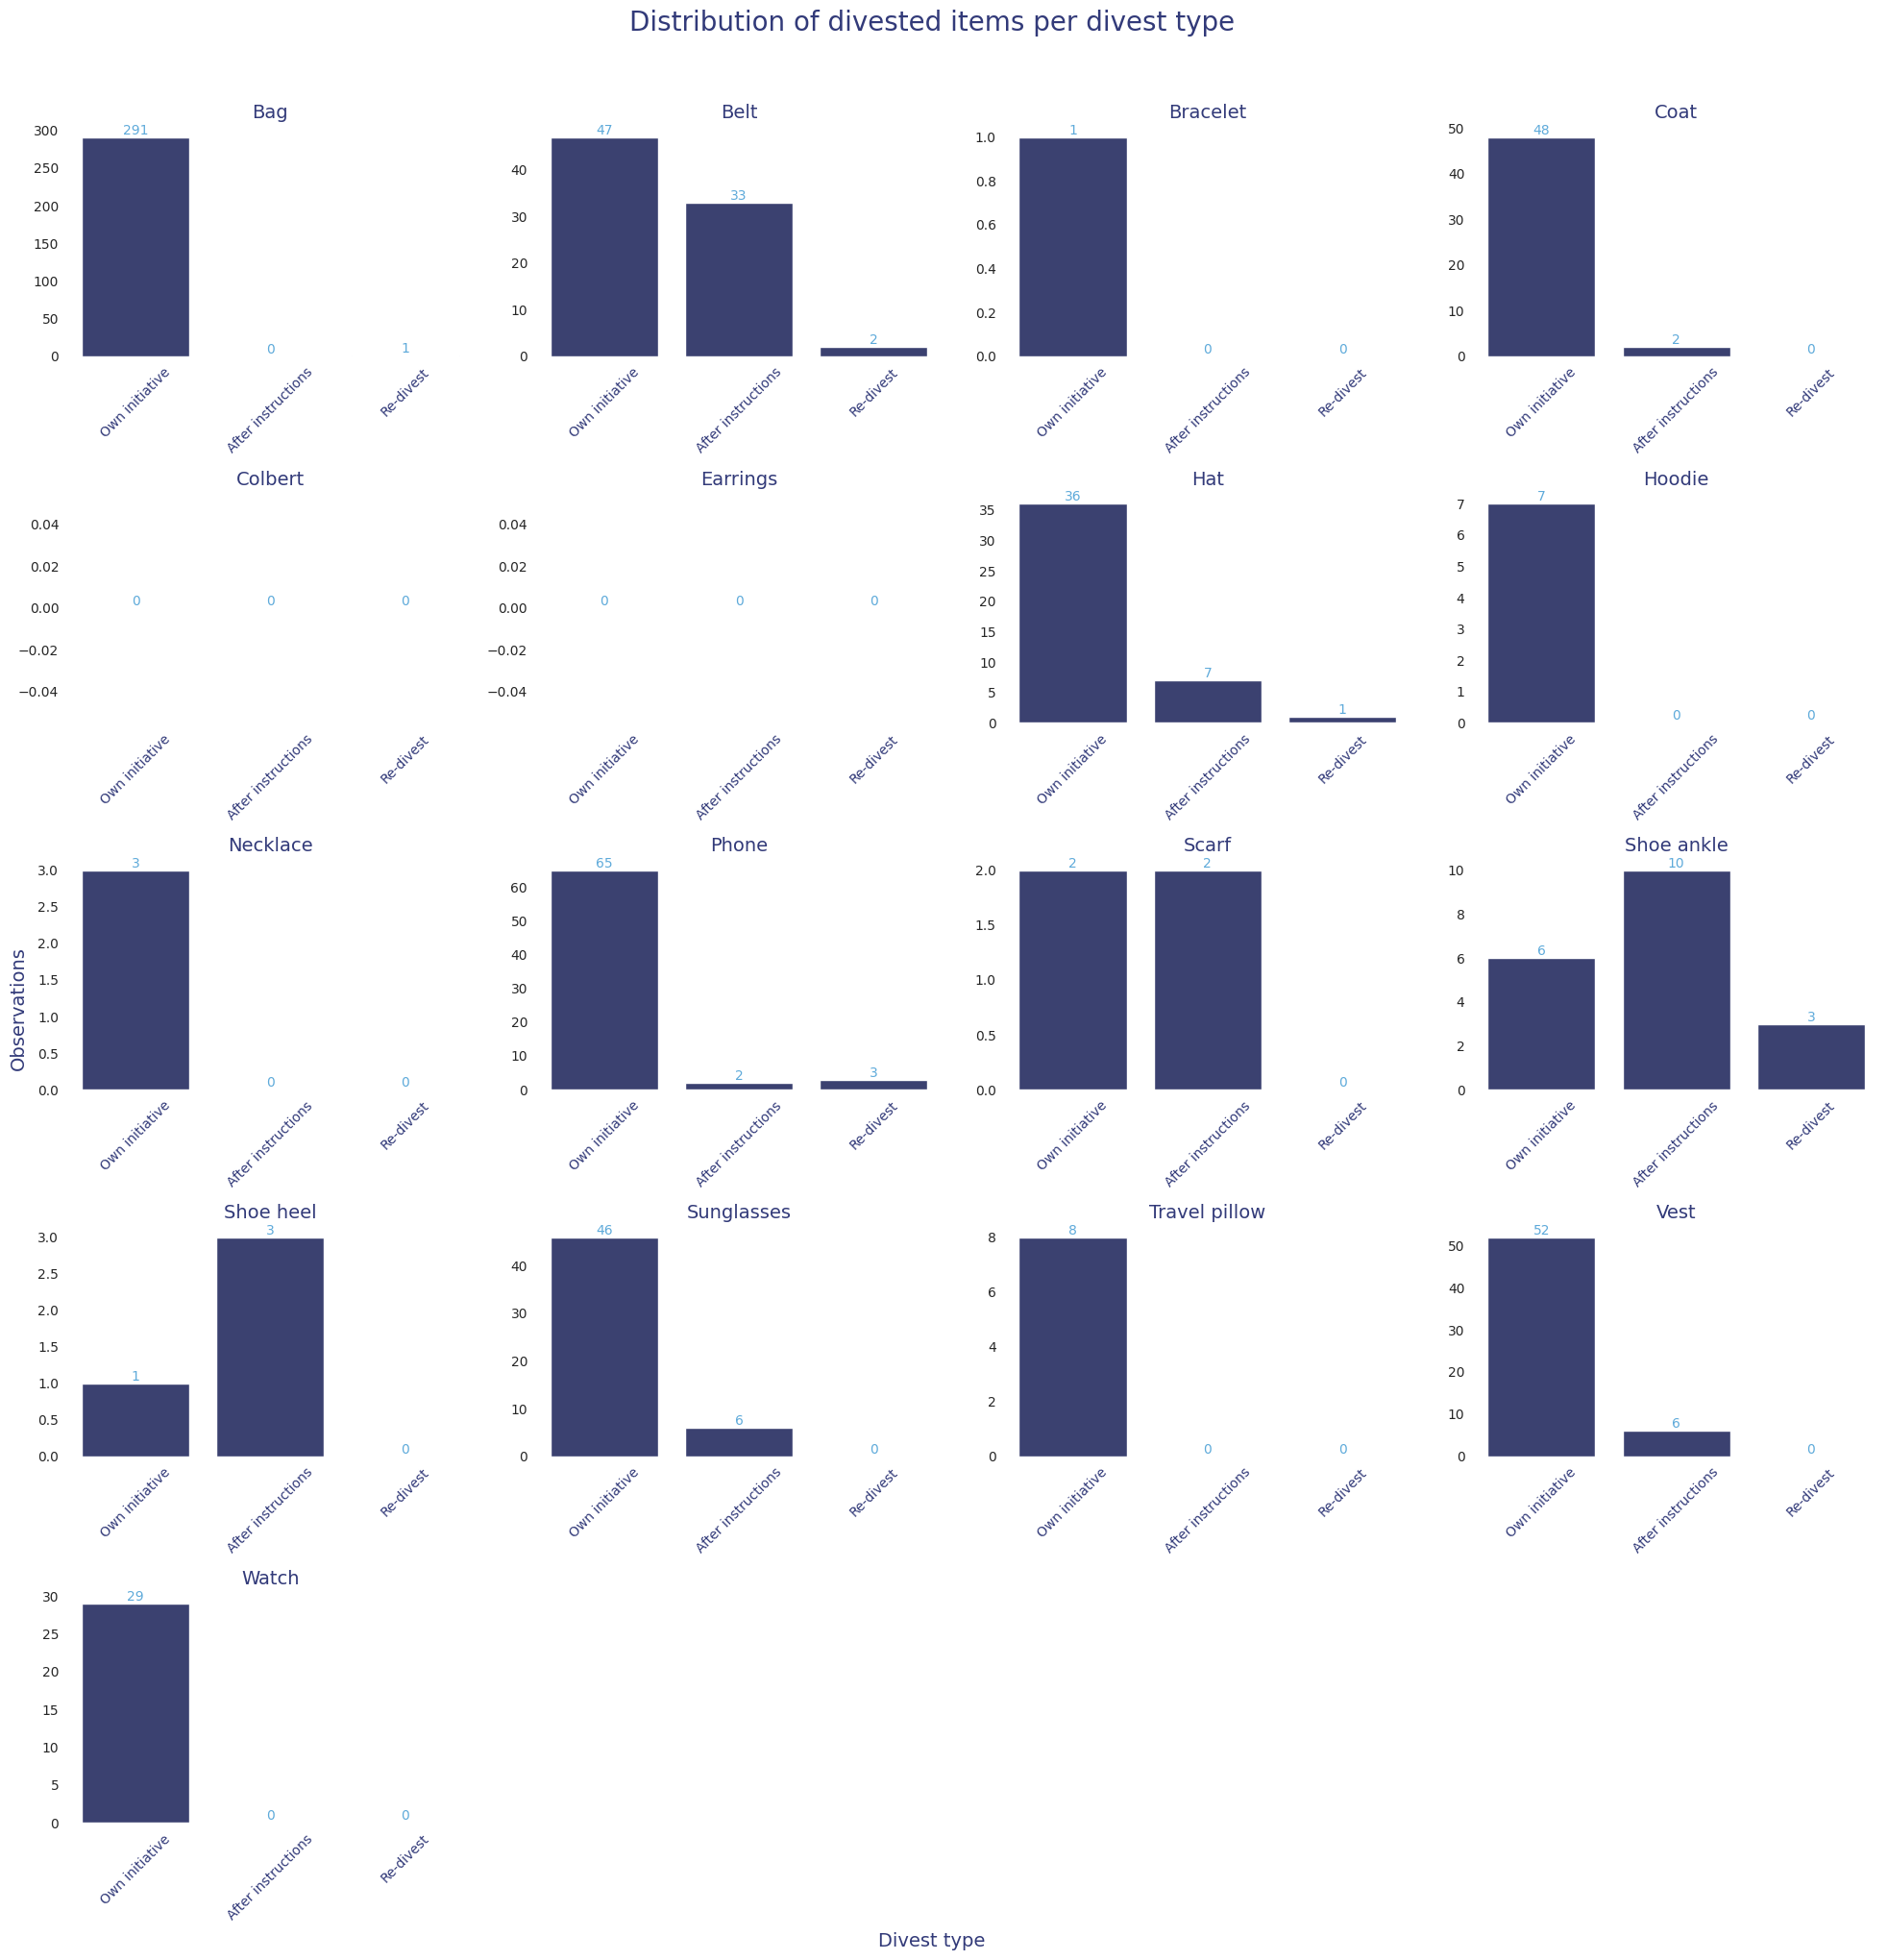

In [14]:
# Items divested

items_divested_columns = [
    'Bag', 'Belt', 'Watch', 'Shoe heel', 'Shoe ankle', 'Phone', 'Sunglasses', 'Coat',
    'Colbert', 'Hat', 'Travel pillow', 'Earrings', 'Bracelet', 'Hoodie', 'Vest', 'Necklace', 'Scarf'
]

# Fix data inconsistency ('Own initiative,Re-divest' should be 'Re-divest')
observations[items_divested_columns] = observations[items_divested_columns].replace('Own initiative,Re-divest', 'Re-divest')
items_divested_counts = observations[items_divested_columns].apply(pd.Series.value_counts).fillna(0).astype(int)

plot_data = items_divested_counts.T.reset_index().melt(id_vars='index', var_name='Reason', value_name='Count')
plot_data = plot_data.rename(columns={'index': 'Item'})
reason_order = ["Own initiative", "After instructions", "Re-divest"]
colors = {
    "primary_dark": "#323a79",
    "primary_light": "#5EAADA",
    "white": "#ffffff",
}

unique_items = plot_data['Item'].nunique()
n_cols = 4
n_rows = (unique_items + n_cols - 1) // n_cols

fig = plt.figure(figsize=(5 * n_cols, 4 * n_rows))

for i, (item_name, group) in enumerate(plot_data.groupby('Item')):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    sns.barplot(
        data=group,
        x='Reason',
        y='Count',
        ax=ax,
        color=colors["primary_dark"],
        order=reason_order
    )
    ax.set_title(item_name, fontsize=14, color=colors["primary_dark"])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(colors=colors["primary_dark"], labelsize=10, axis='x', rotation=45)
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom',
                    color=colors["primary_light"],
                    fontsize=10)
    for spine in ax.spines.values():
        spine.set_visible(False)

fig.suptitle('Distribution of divested items per divest type', fontsize=20, color=colors["primary_dark"], y=1.02)
fig.supxlabel('Divest type', fontsize=14, color=colors["primary_dark"])
fig.supylabel('Observations', fontsize=14, color=colors["primary_dark"])
plt.tight_layout()
plt.savefig('divested_items_per_type.pdf', bbox_inches='tight', dpi=300)
plt.show()




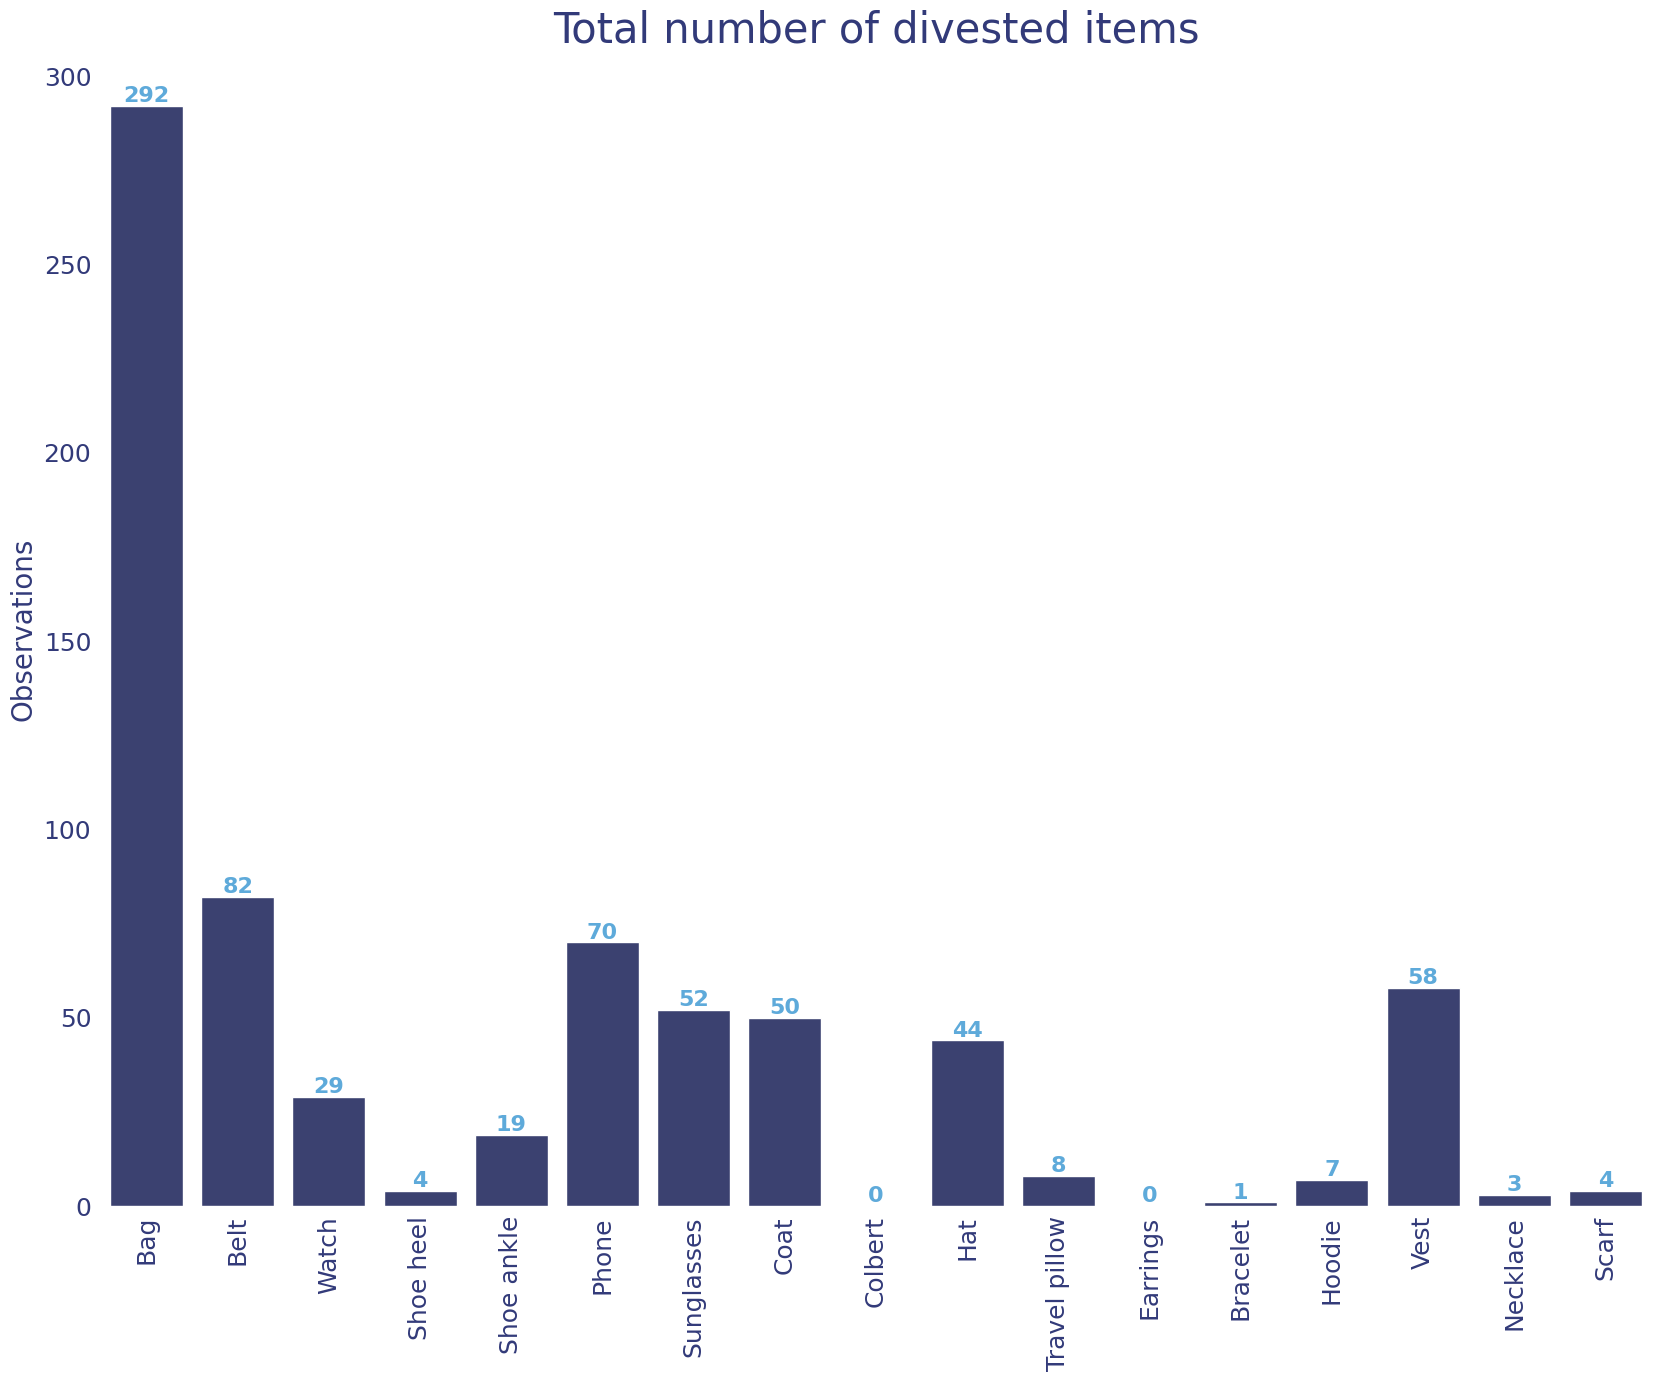

In [15]:
items_divested_counts_total = items_divested_counts.sum().reset_index()
items_divested_counts_total.columns = ['Item', 'Count']
generate_histogram(
    items_divested_counts_total,
    title='Total number of divested items',
    x='Item',
    y='Count',
    name_to_save="total_divested_items_histogram.pdf",
    rotation=90,
    xlabel='',
    ylabel='Observations',
)

In [16]:
# ...existing code...
total_passengers = 296
z = 1.96  # 95% confidence interval

# Wilson score interval calculation
p = items_divested_counts_total['Count'] / total_passengers
n = total_passengers

denom = 1 + z**2 / n
center = (p + z**2 / (2 * n)) / denom
margin = (z * np.sqrt((p * (1 - p) + z**2 / (4 * n)) / n)) / denom

items_divested_counts_total['Proportion'] = p
items_divested_counts_total['CI_lower'] = (center - margin).clip(lower=0)
items_divested_counts_total['CI_upper'] = (center + margin).clip(upper=1)

# Optional: display the table
items_divested_counts_total[['Item', 'Count', 'Proportion', 'CI_lower', 'CI_upper']]

items_divested_counts_total


,Item,Count,Proportion,CI_lower,CI_upper
0,Bag,292,0.986486,0.965774,0.994733
1,Belt,82,0.277027,0.229147,0.330620
2,Watch,29,0.097973,0.069083,0.137165
3,Shoe heel,4,0.013514,0.005267,0.034226
4,Shoe ankle,19,0.064189,0.041475,0.098071
5,Phone,70,0.236486,0.191647,0.288078
6,Sunglasses,52,0.175676,0.136557,0.223105
7,Coat,50,0.168919,0.130539,0.215783
8,Colbert,0,0.000000,0.000000,0.012812
9,Hat,44,0.148649,0.112633,0.193668


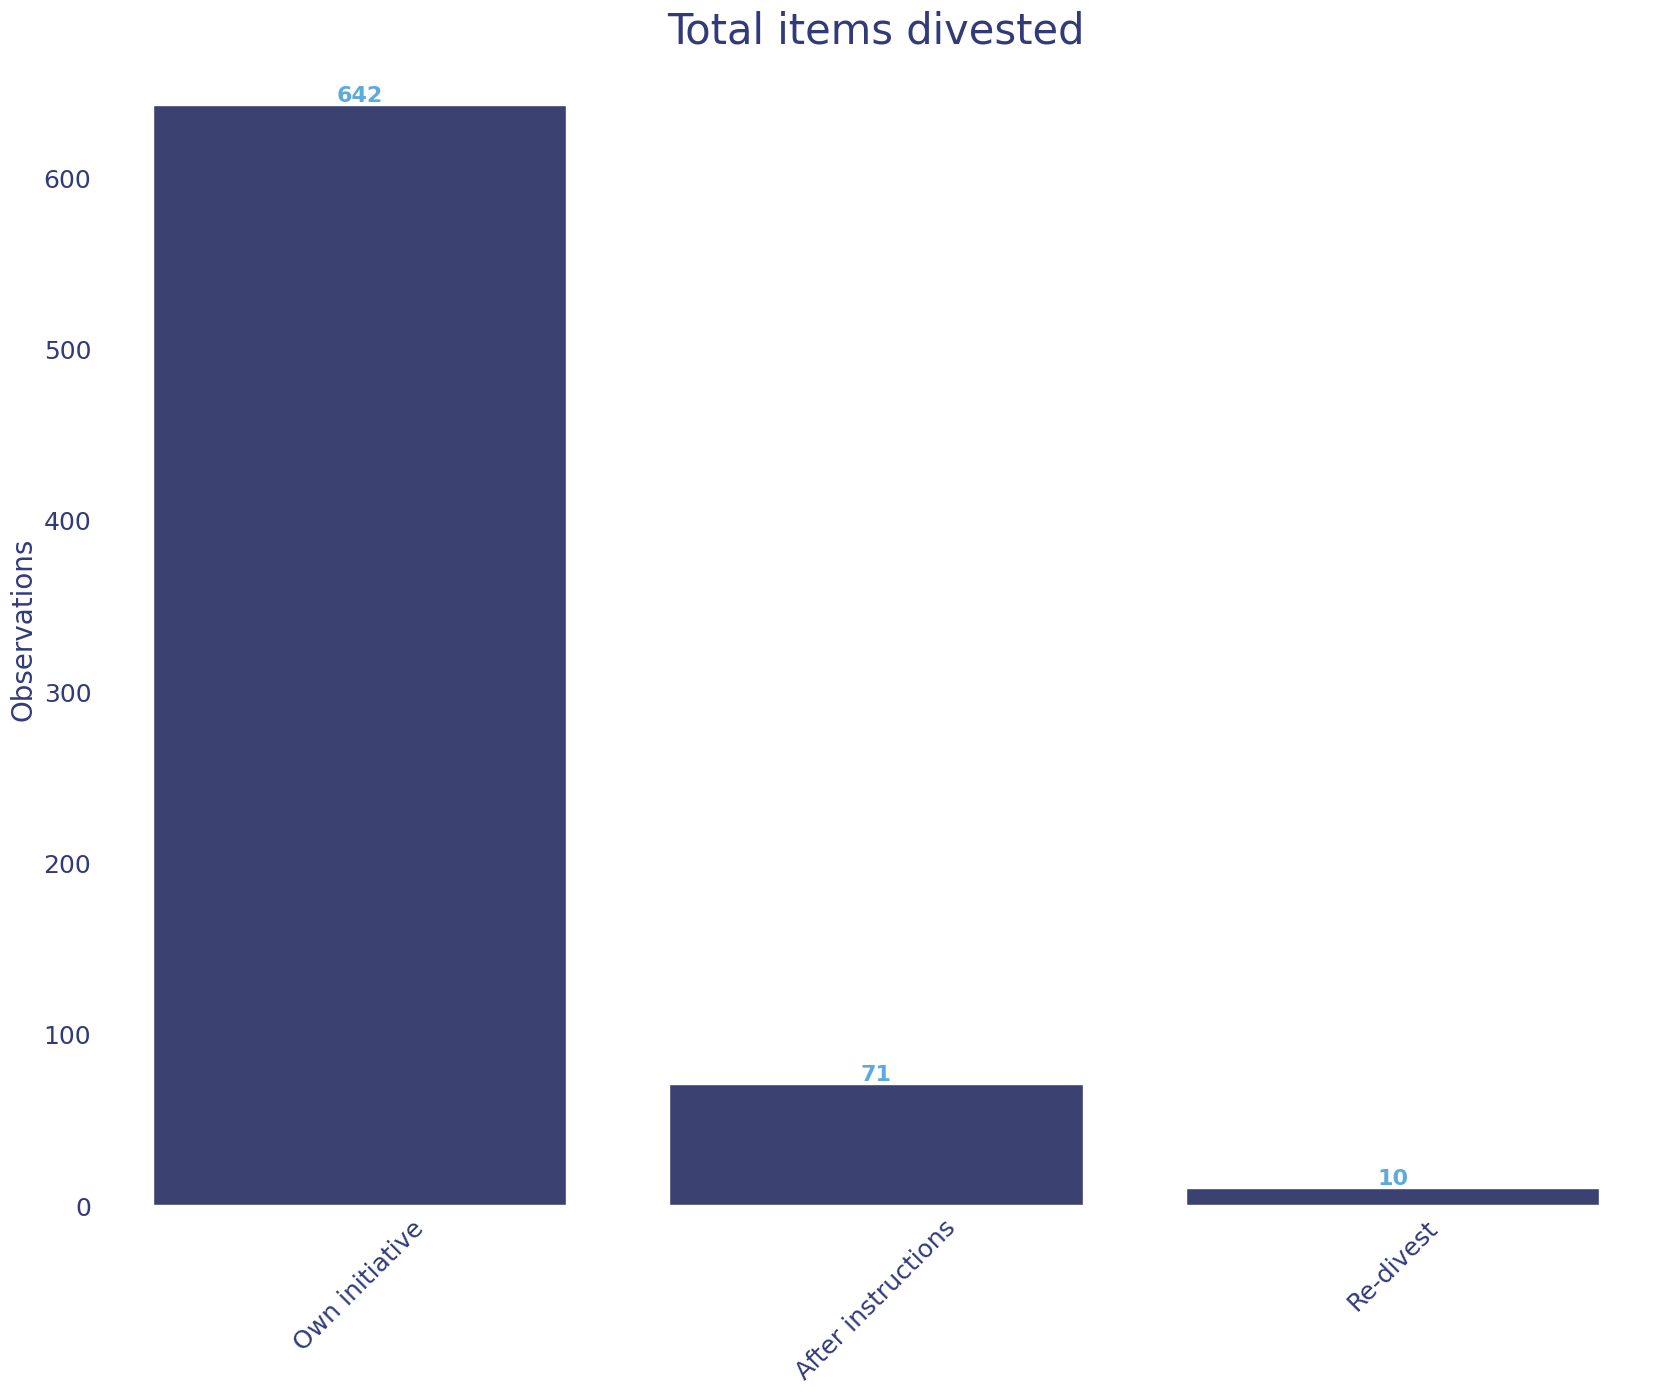

In [17]:
items_divested_counts['Total'] = items_divested_counts.sum(axis=1)
items_divested_counts_reset = items_divested_counts.reset_index()

# Sort by your desired order
reason_order = ["Own initiative", "After instructions", "Re-divest"]
items_divested_counts_reset = items_divested_counts_reset.set_index('index').loc[reason_order].reset_index()

generate_histogram(
    items_divested_counts_reset,
    title='Total items divested',
    x='index',
    y='Total',
    name_to_save="total_items_divested_histogram.pdf",
    rotation=45,
    xlabel='',
    ylabel='Observations',
)

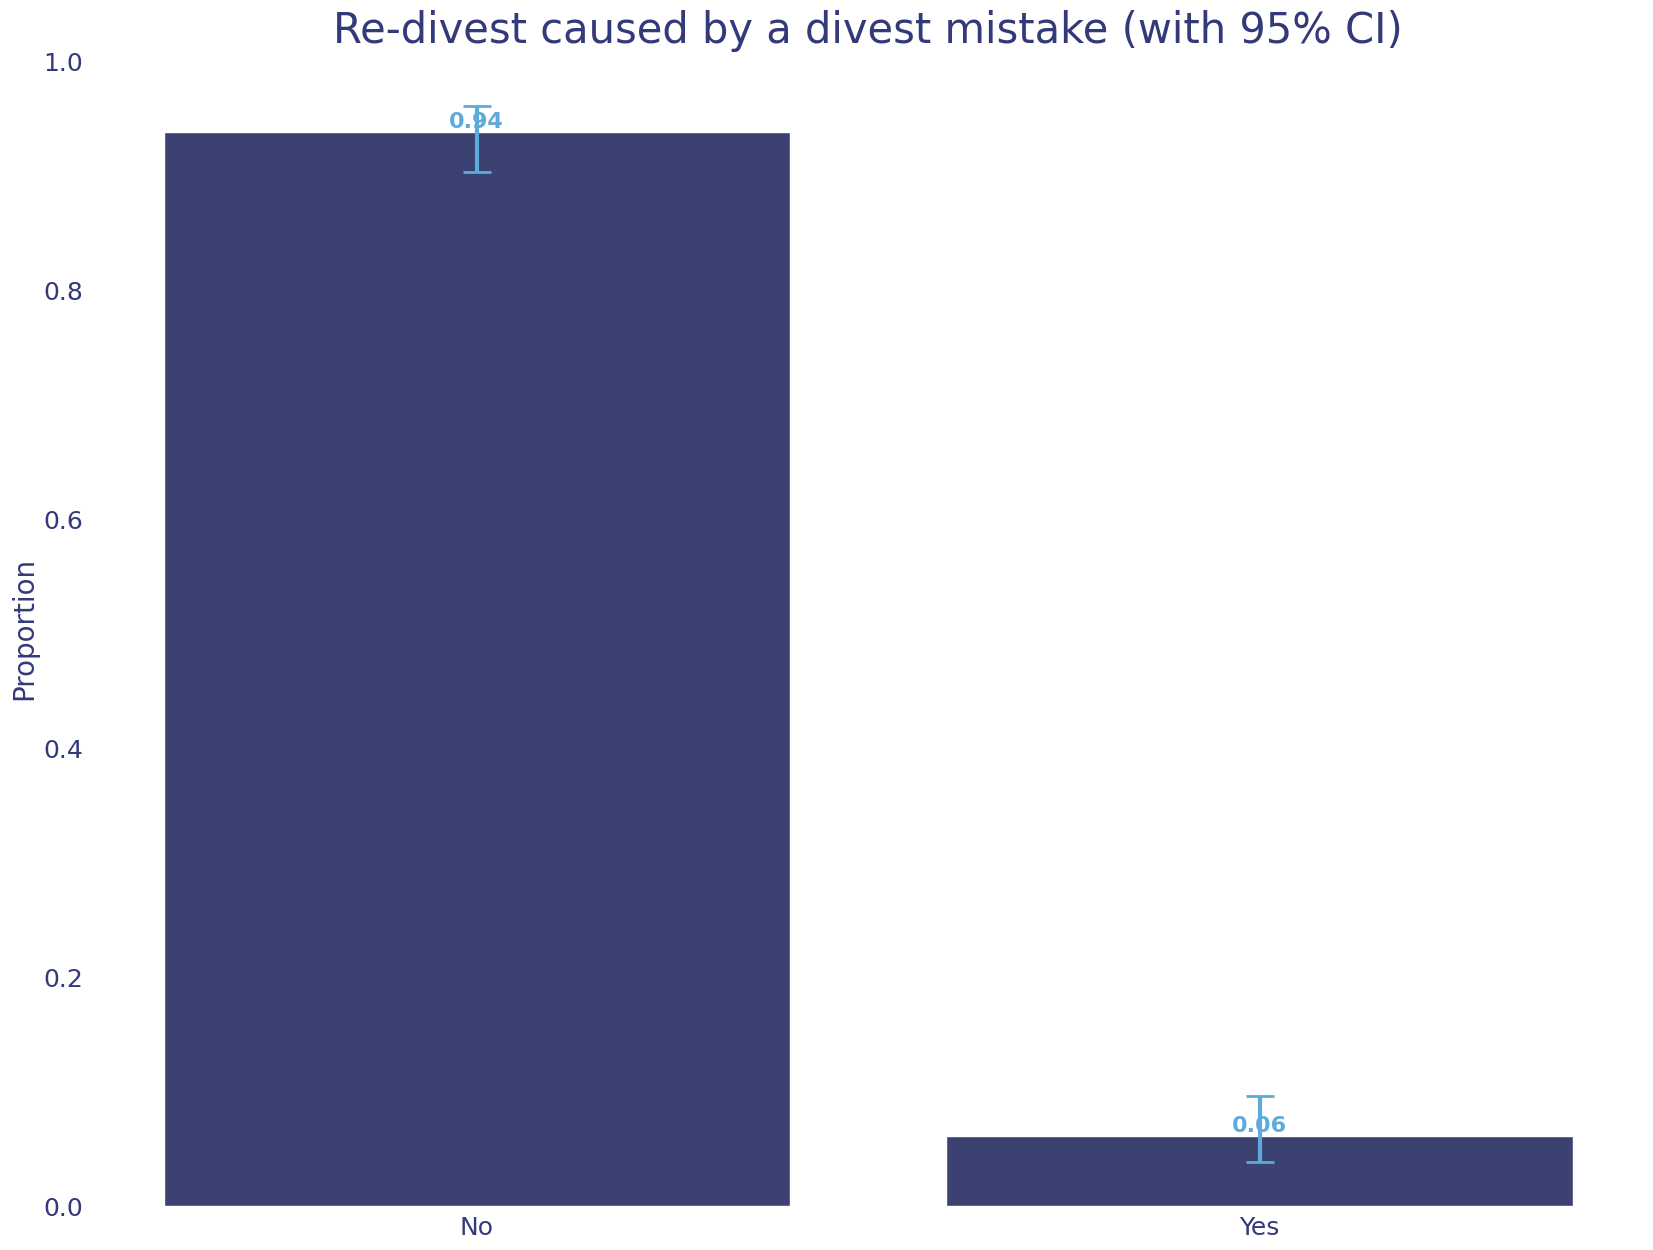

In [18]:
def generate_histogram_bounds(
    data: pd.DataFrame,
    x: str,
    y: str,
    title: str,
    xlabel: str,
    ylabel: str,
    name_to_save: str,
    rotation: int,
    yerr_lower: str = None,
    yerr_upper: str = None
) -> None:
    colors = {
        "primary_dark": "#323a79",
        "primary_light": "#5EAADA",
        "white": "#ffffff",
    }
    sns.set_style("white")

    plt.figure(figsize=(20, 15))
    bar_plot = sns.barplot(
        data=data,
        x=x,
        y=y,
        color=colors["primary_dark"],
        errorbar=None  # We'll add error bars manually if needed
    )

    # Add error bars if columns are provided
    if yerr_lower and yerr_upper and yerr_lower in data.columns and yerr_upper in data.columns:
        x_coords = [p.get_x() + p.get_width() / 2. for p in bar_plot.patches]
        y_vals = data[y].values
        lower = y_vals - data[yerr_lower].values
        upper = data[yerr_upper].values - y_vals
        plt.errorbar(
            x=x_coords,
            y=y_vals,
            yerr=[lower, upper],
            fmt='none',
            ecolor=colors["primary_light"],
            elinewidth=3,
            capsize=10,
            capthick=2,
            zorder=10
        )

    # Add value labels on top of the bars
    for p in bar_plot.patches:
        bar_plot.annotate(f'{p.get_height():.2f}' if yerr_lower else f'{int(p.get_height())}',
                          (p.get_x() + p.get_width() / 2., p.get_height()),
                          ha='center', va='bottom',
                          color=colors["primary_light"],
                          fontsize=16, fontweight='bold')

    # Title and axis formatting
    plt.title(title, fontsize=30, color=colors["primary_dark"])
    plt.xlabel(xlabel, fontsize=20, color=colors["primary_dark"])
    plt.ylabel(ylabel, fontsize=20, color=colors["primary_dark"])
    bar_plot.tick_params(colors=colors["primary_dark"])
    plt.xticks(fontsize=18, rotation=rotation, ha='center')
    plt.yticks(fontsize=18)
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    plt.savefig(f'{name_to_save}.pdf', dpi=300, bbox_inches='tight')
    plt.show()


redivest_counts = observations["Was a redivest caused by an error?"].value_counts().reset_index()
# ...existing code...

# Calculate value counts and proportions for "Was a redivest caused by an error?"
redivest_counts = observations["Was a redivest caused by an error?"].value_counts().reset_index()
redivest_counts.columns = ['Was a redivest caused by an error?', 'Count']
total = redivest_counts['Count'].sum()
redivest_counts['Proportion'] = redivest_counts['Count'] / total

# Calculate Wilson score confidence intervals
z = 1.96  # 95% CI
n = total
p = redivest_counts['Proportion']

denom = 1 + z**2 / n
center = (p + z**2 / (2 * n)) / denom
margin = (z * np.sqrt((p * (1 - p) + z**2 / (4 * n)) / n)) / denom

redivest_counts['CI_lower'] = (center - margin).clip(lower=0)
redivest_counts['CI_upper'] = (center + margin).clip(upper=1)

generate_histogram_bounds(
    redivest_counts,
    x='Was a redivest caused by an error?',
    y='Proportion',
    title='Re-divest caused by a divest mistake (with 95% CI)',
    xlabel='',
    ylabel='Proportion',
    name_to_save="redivest_error_histogram_with_ci.pdf",
    rotation=0,
    yerr_lower='CI_lower',
    yerr_upper='CI_upper'
)
# ...existing code...

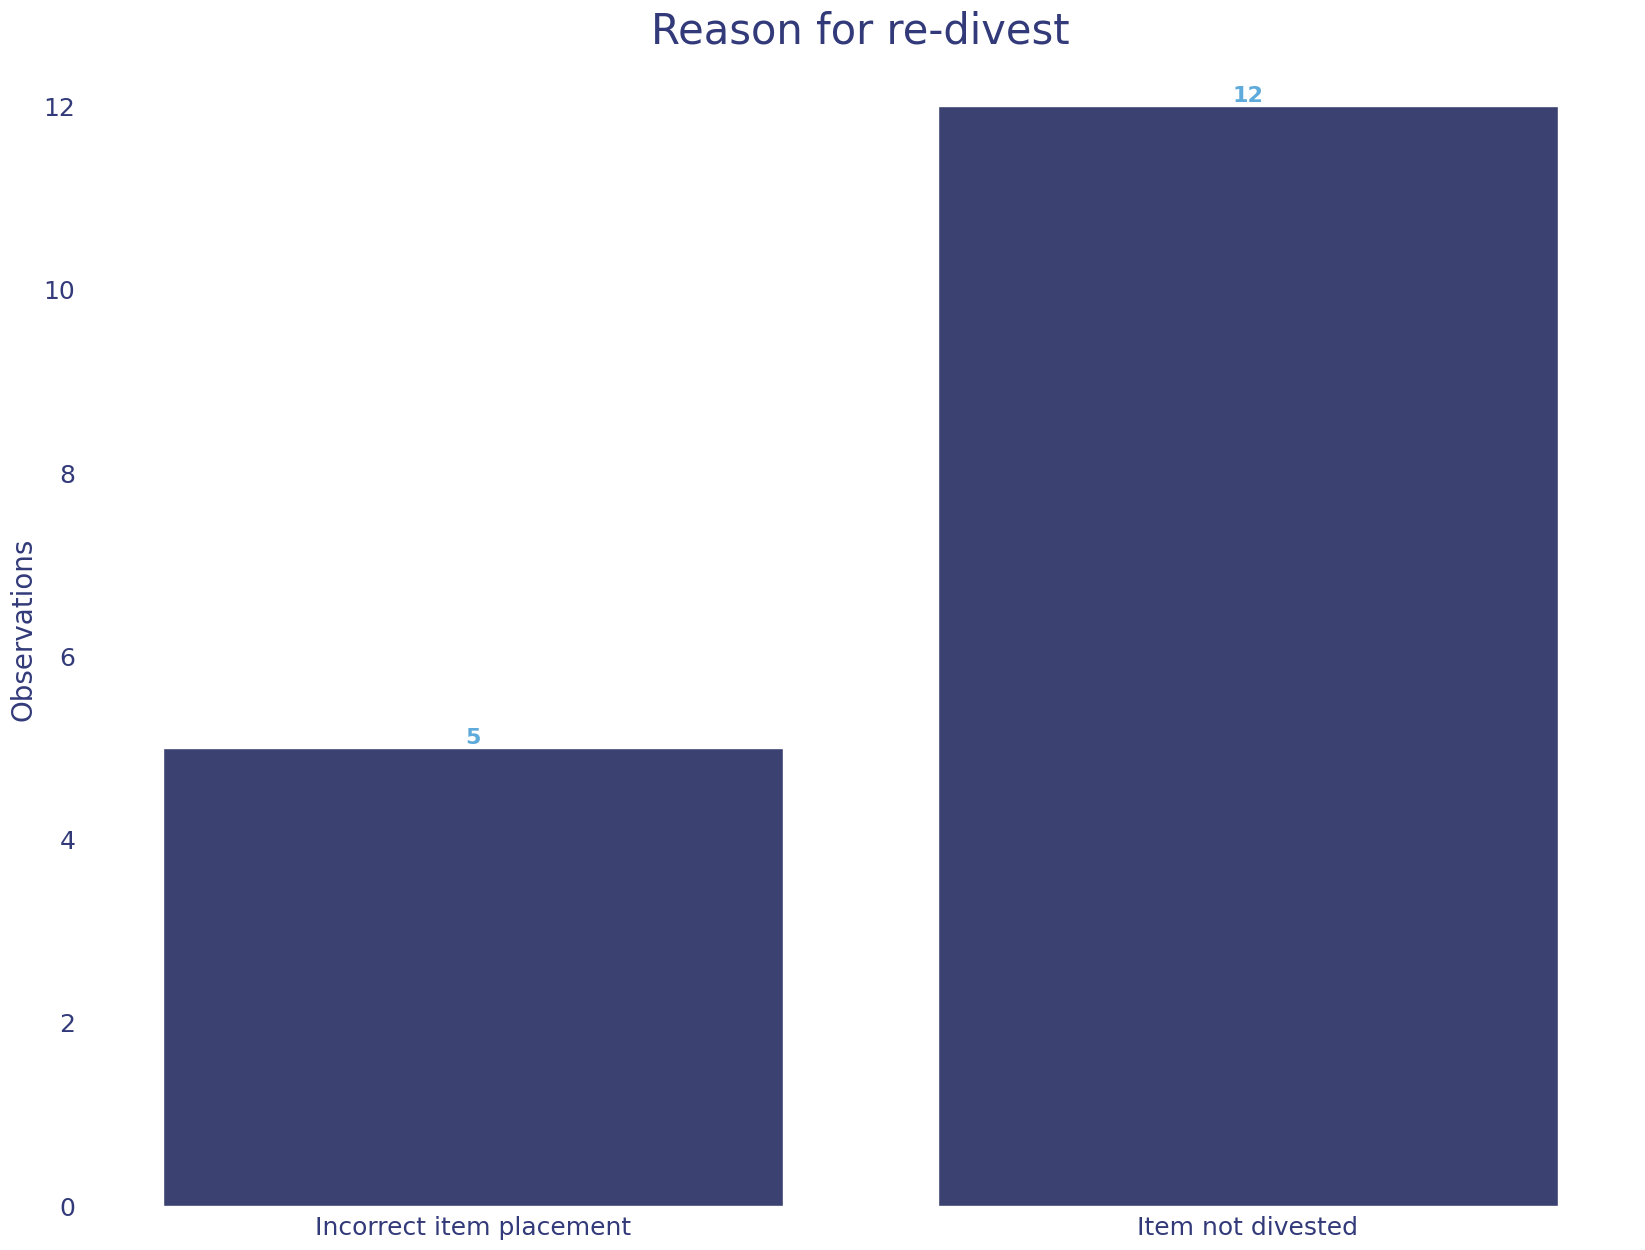

In [19]:
redivest_reason = ["Incorrect item placement", "Item not divested"]
redivest_reason_counts = [5, 12]
redivest_reason_df = pd.DataFrame({
    'Reason': redivest_reason,
    'Count': redivest_reason_counts
})
generate_histogram(
    redivest_reason_df,
    title='Reason for re-divest',
    x='Reason',
    y='Count',
    name_to_save="redivest_reason_histogram.pdf",
    rotation=0,
    xlabel='',
    ylabel='Observations',
)

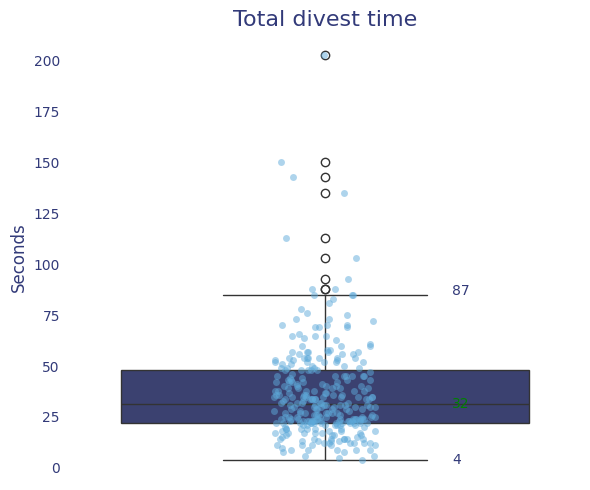

In [20]:
plt.figure(figsize=(6, 5))
ax = sns.boxplot(
    data=observations,
    y="Total divest time in seconds",
    color=colors["primary_dark"]
)
sns.stripplot(
    data=observations,
    y="Total divest time in seconds",
    color=colors["primary_light"],
    alpha=0.5
)
plt.title("Total divest time", fontsize=16, color=colors["primary_dark"])
plt.ylabel("Seconds", fontsize=12, color=colors["primary_dark"])
plt.xlabel("")
plt.tick_params(colors=colors["primary_dark"])
for spine in plt.gca().spines.values():
    spine.set_visible(False)


y = observations["Total divest time in seconds"].dropna()
q1 = y.quantile(0.25)
q3 = y.quantile(0.75)
median = y.median()
iqr = q3 - q1
lower_whisker = max(y.min(), q1 - 1.5 * iqr)
upper_whisker = min(y.max(), q3 + 1.5 * iqr)
outliers = y[(y < lower_whisker) | (y > upper_whisker)]

# Annotate median
plt.text(0.25, median, f"{int(round(median))}", color="green", fontsize=10, va='center')
# Annotate whiskers
plt.text(0.25, lower_whisker, f"{int(round(lower_whisker))}", color=colors["primary_dark"], fontsize=10, va='center')
plt.text(0.25, upper_whisker, f"{int(round(upper_whisker))}", color=colors["primary_dark"], fontsize=10, va='center')


plt.tight_layout()
plt.savefig("total_divest_time_boxplot_with_dots_labels.pdf", bbox_inches='tight', dpi=300)
plt.show()

In [21]:
logger.info(f"Average total divest time: {int(observations['Total divest time in seconds'].mean())} seconds")
logger.info(f"Average re-divest time: {int(observations['Re-divest time if applicable'].mean())} seconds")
logger.info(f"Average re-divest time when one or more items are not divested: {int(np.array([10,11,18,24,3,5,8,3,35,5,5,0]).mean())} seconds")
logger.info(f"Average re-divest time when items are incorrectly placed on the tray: {int(np.array([162, 168, 287, 113]).mean())} seconds")

2025-06-24 15:52:45.387 | INFO     | __main__:<module>:1 - Average total divest time: 36 seconds
2025-06-24 15:52:45.388 | INFO     | __main__:<module>:2 - Average re-divest time: 48 seconds
2025-06-24 15:52:45.388 | INFO     | __main__:<module>:3 - Average re-divest time when one or more items are not divested: 10 seconds
2025-06-24 15:52:45.389 | INFO     | __main__:<module>:4 - Average re-divest time when items are incorrectly placed on the tray: 182 seconds


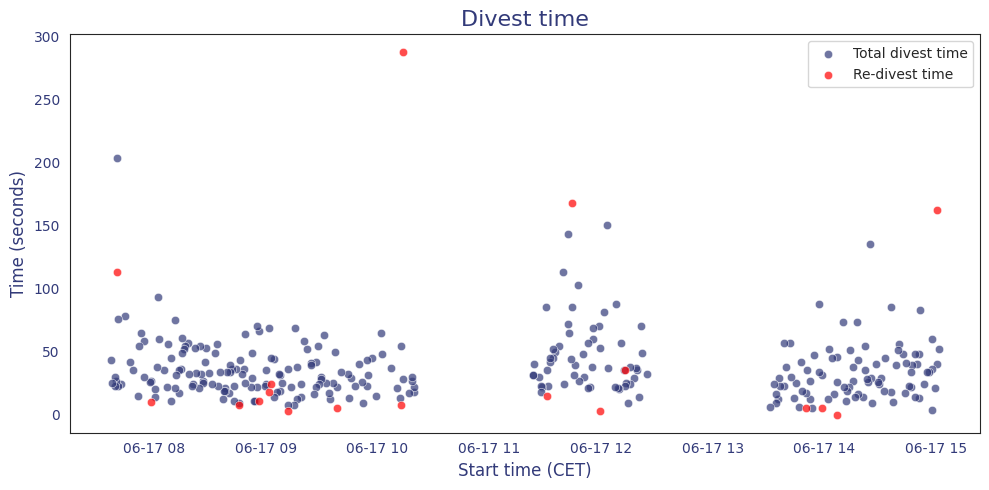

In [22]:
plt.figure(figsize=(10, 5))
# Convert Start Date (UTC) to datetime if not already, then localize and convert to CET
observations['Start Date (UTC)'] = pd.to_datetime(observations['Start Date (UTC)'])
observations['Start Date (CET)'] = (
    observations['Start Date (UTC)']
    .dt.tz_localize('UTC')
    .dt.tz_convert('Europe/Amsterdam')
)

# Plot Total divest time in seconds
sns.scatterplot(
    data=observations,
    x='Start Date (CET)',
    y='Total divest time in seconds',
    color=colors["primary_dark"],
    alpha=0.7,
    label="Total divest time"
)

# Plot Re-divest time if applicable (red markers)
sns.scatterplot(
    data=observations,
    x='Start Date (CET)',
    y='Re-divest time if applicable',
    color='red',
    alpha=0.7,
    label="Re-divest time"
)

plt.title("Divest time", fontsize=16, color=colors["primary_dark"])
plt.xlabel("Start time (CET)", fontsize=12, color=colors["primary_dark"])
plt.ylabel("Time (seconds)", fontsize=12, color=colors["primary_dark"])
plt.tick_params(colors=colors["primary_dark"])
plt.legend()
plt.tight_layout()
plt.savefig("divest_and_redivest_time_vs_start_date.pdf", bbox_inches='tight', dpi=300)
plt.show()

Questions present: 83
Unique questions: 79
Instructions present: 219
Unique instructions: 179
Most common questions:
 Questions asked by passenger
Belt?                          3
Shoes off?                     2
Remove jewelry?                2
Do i need to take of shoes?    1
Sunglasses?                    1
Name: count, dtype: int64
Most common instructions:
 Instructions provided by operator
Pockets     8
No          6
Liquids     6
Same        5
Liquids?    4
Name: count, dtype: int64


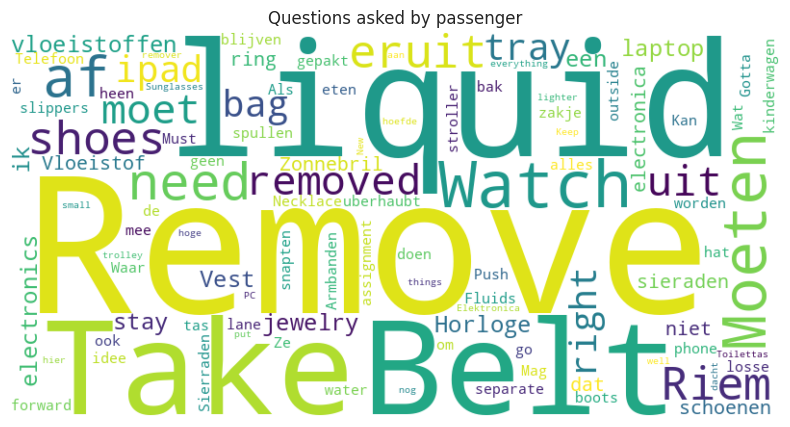

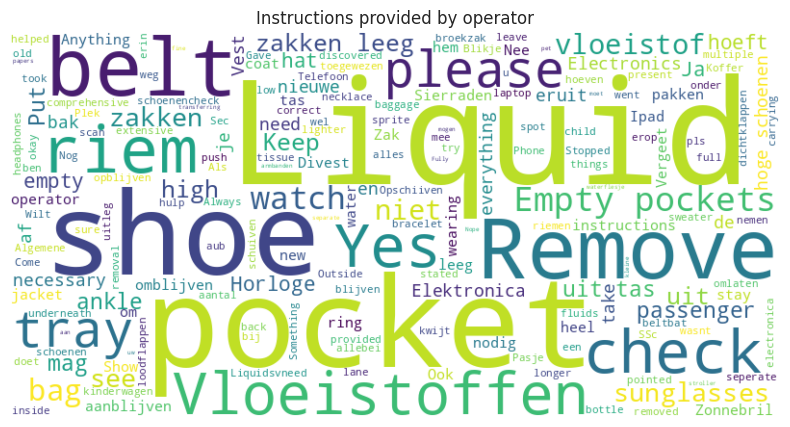

In [23]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Columns
question_col = "Questions asked by passenger"
instruction_col = "Instructions provided by operator"

# 1. Basic stats
print("Questions present:", observations[question_col].notna().sum())
print("Unique questions:", observations[question_col].nunique())
print("Instructions present:", observations[instruction_col].notna().sum())
print("Unique instructions:", observations[instruction_col].nunique())

# 2. Most common
print("Most common questions:\n", observations[question_col].value_counts().head())
print("Most common instructions:\n", observations[instruction_col].value_counts().head())

# 3. Word cloud for questions
text = " ".join(observations[question_col].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Questions asked by passenger")
plt.show()

# 4. Word cloud for instructions
text = " ".join(observations[instruction_col].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Instructions provided by operator")
plt.show()

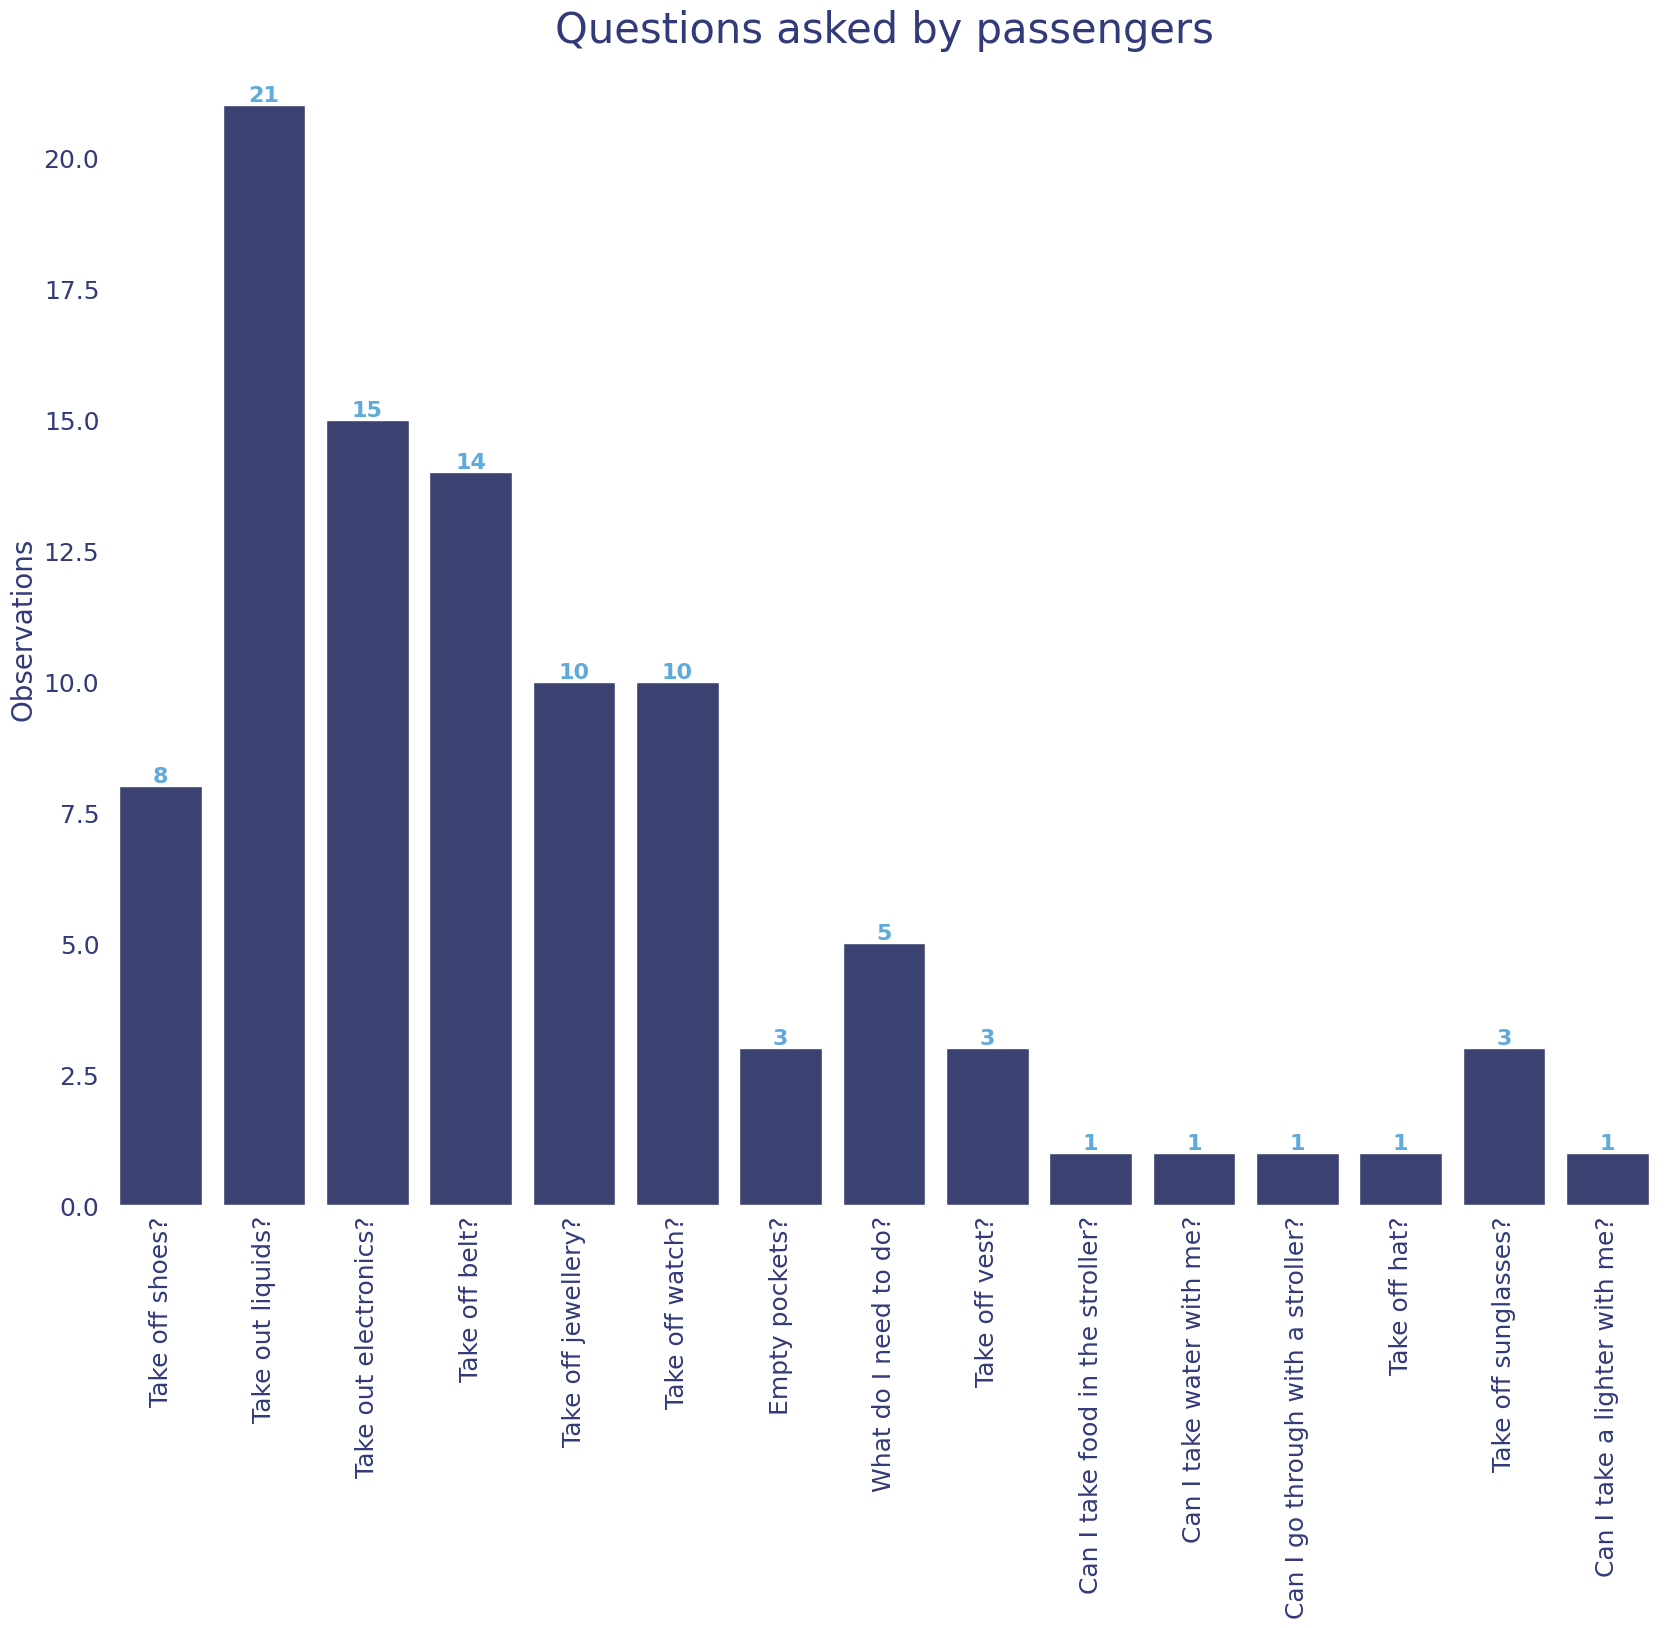

In [24]:
questions_categorized = ["Take off shoes?", "Take out liquids?", "Take out electronics?", "Take off belt?", "Take off jewellery?", "Take off watch?", "Empty pockets?", "What do I need to do?", "Take off vest?", "Can I take food in the stroller?", "Can I take water with me?", "Can I go through with a stroller?", "Take off hat?", "Take off sunglasses?", "Can I take a lighter with me?"]
questions_categorized_counts = [
    8,   # Take off shoes?
    21,  # Take out liquids?
    15,  # Take out electronics?
    14,  # Take off belt?
    10,  # Take off jewellery?
    10,  # Take off watch?
    3,   # Empty pockets?
    5,   # What do I need to do?
    3,   # Take off vest?
    1,   # Can I take food in the stroller?
    1,   # Can I take water with me?
    1,   # Can I go through with a stroller?
    1,   # Take off hat?
    3,   # Take off sunglasses?
    1    # Can I take a lighter with me?
]

# DUBBELCHECK THIS
questions_categorized_df = pd.DataFrame({
    'Question': questions_categorized,
    'Count': questions_categorized_counts
})
generate_histogram(
    questions_categorized_df,
    title='Questions asked by passengers',
    x='Question',
    y='Count',
    name_to_save="questions_asked_by_passengers_histogram.pdf",
    rotation=90,
    xlabel='',
    ylabel='Observations',
)


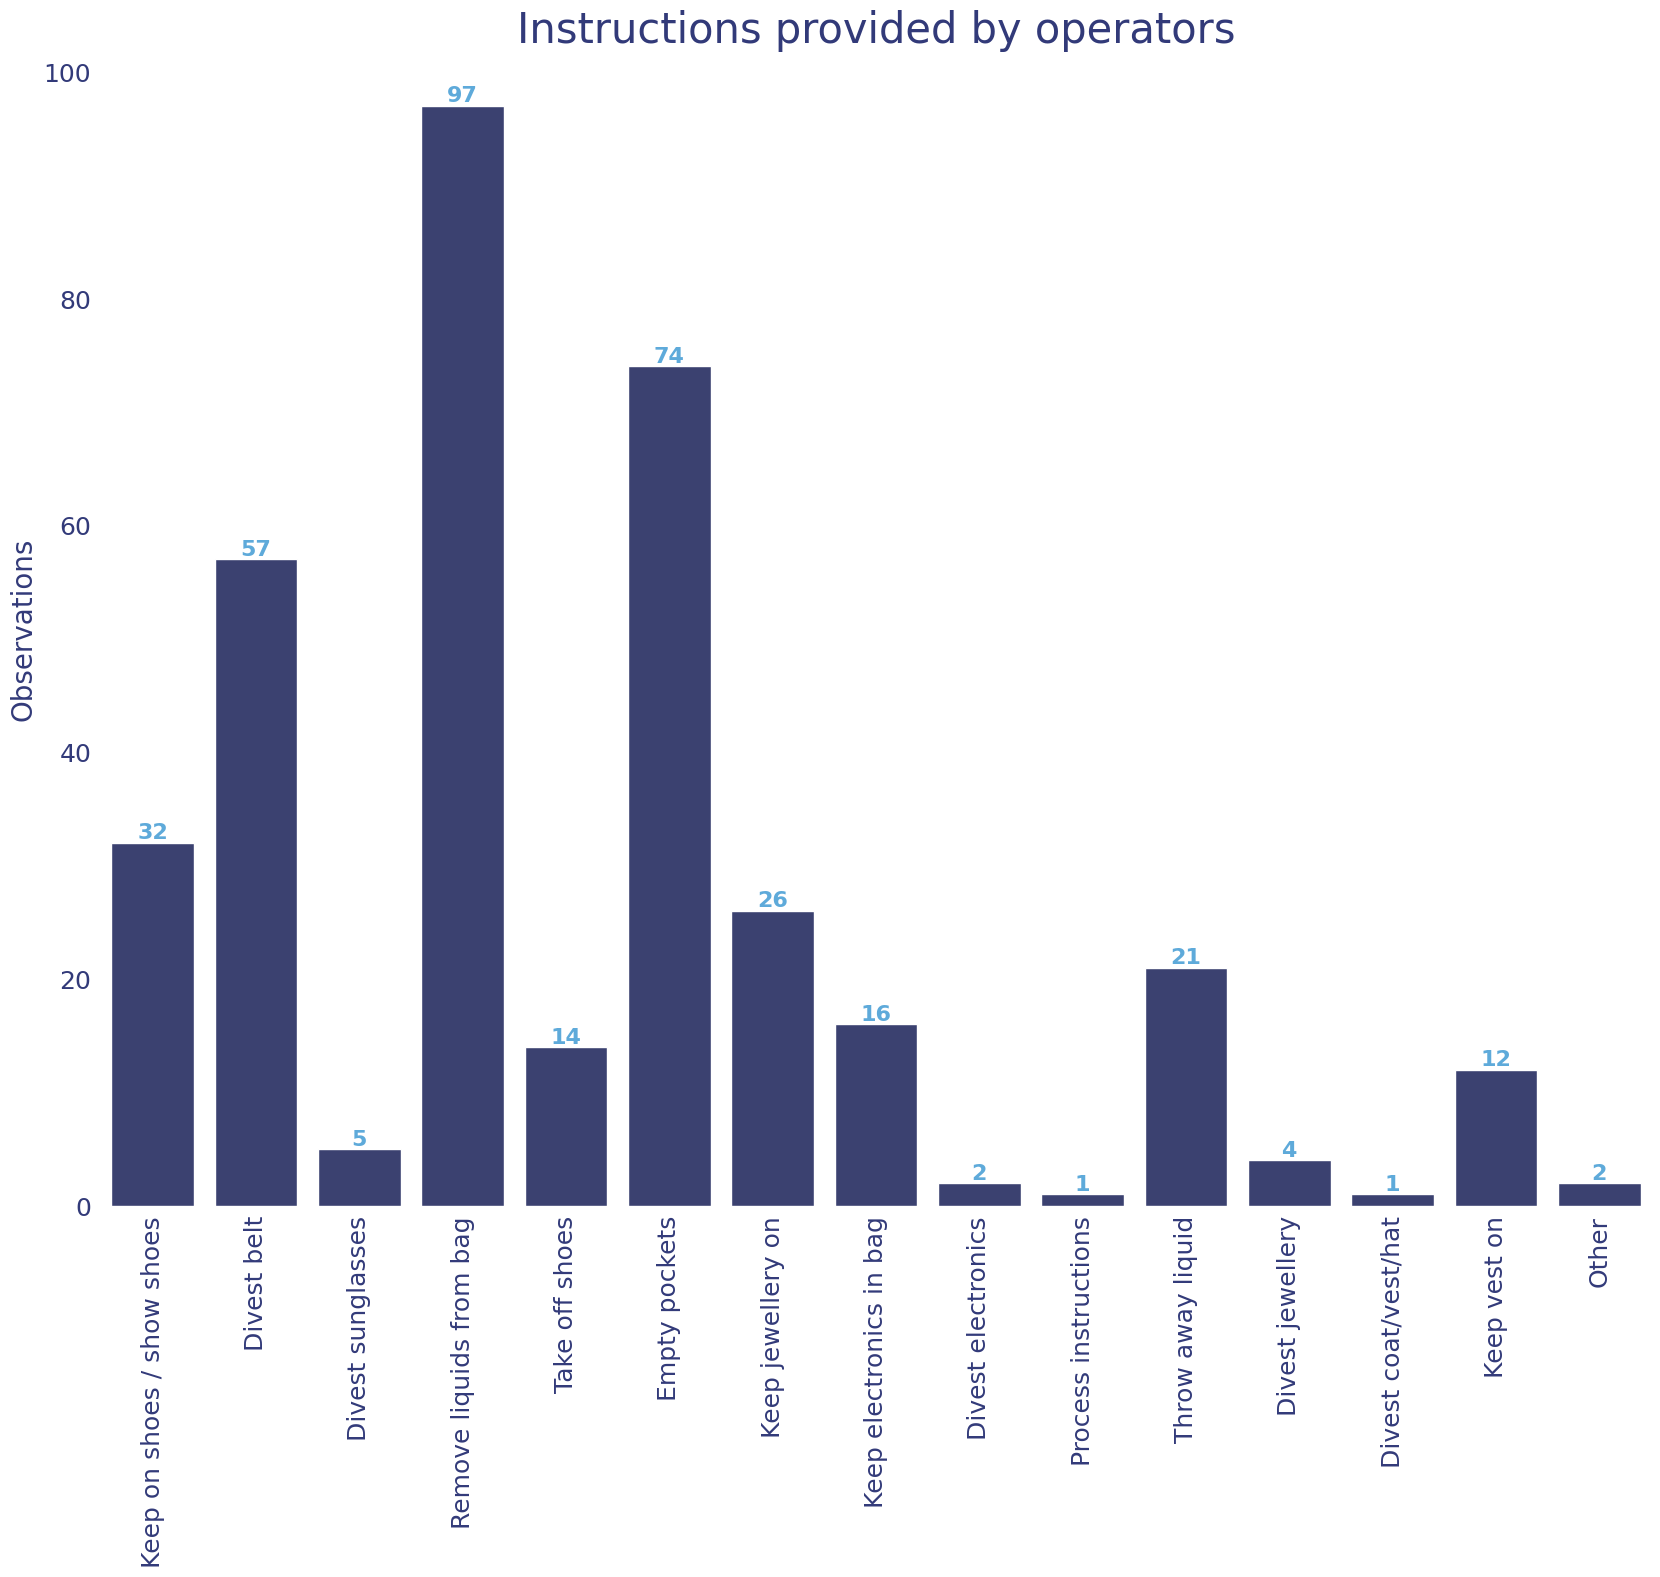

In [25]:
instructions_categorized = ["Keep on shoes / show shoes", "Divest belt", "Divest sunglasses", "Remove liquids from bag", "Take off shoes", "Empty pockets", "Keep jewellery on", "Keep electronics in bag", "Divest electronics", "Process instructions", "Throw away liquid", "Divest jewellery", "Divest coat/vest/hat", "Keep vest on", "Other"]
insruction_counts = [32, 57, 5, 97, 14, 74, 26, 16, 2, 1, 21, 4, 1, 12, 2]
instructions_categorized_df = pd.DataFrame({
    'Instruction': instructions_categorized,
    'Count': insruction_counts
})
generate_histogram(
    instructions_categorized_df,
    title='Instructions provided by operators',
    x='Instruction',
    y='Count',
    name_to_save="instructions_provided_by_operators_histogram.pdf",
    rotation=90,
    xlabel='',
    ylabel='Observations',
)
